In [21]:
import warnings
warnings.filterwarnings(action='ignore')
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import PIL
import pathlib

from glob import glob
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from keras.models import load_model

In [23]:
from matplotlib import rc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트 관련 용도
 
%config InlineBackend.figure_format = 'retina'
# 디렉토리 및 파일 이름에 맞추어 변경
font_location = 'C:/Windows/Fonts/malgun.ttf'#윈도우안에있는 폰트파일주소.
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [2]:
print(os.getcwd()) 

C:\Users\hi\Anaconda3\jupiter\day22_mongoDB_chatbot\chatbot_Project(4category)


In [3]:
# 파일 경로 재설정
base_dir = os.chdir("C:/Users/hi/Anaconda3/jupiter/day22_mongoDB_chatbot/chatbot_Project(4category)/cloud_data/train/train_all")
print(os.getcwd())

C:\Users\hi\Anaconda3\jupiter\day22_mongoDB_chatbot\chatbot_Project(4category)\cloud_data\train\train_all


In [4]:
print(os.getcwd())

C:\Users\hi\Anaconda3\jupiter\day22_mongoDB_chatbot\chatbot_Project(4category)\cloud_data\train\train_all


In [5]:
data_dir = pathlib.Path(os.getcwd())

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2323


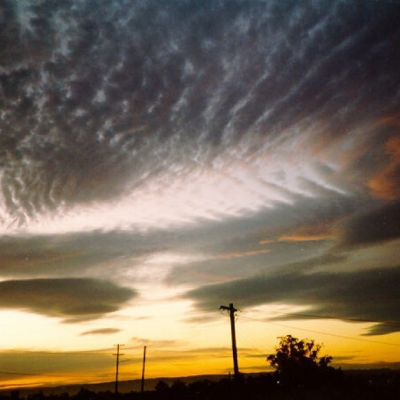

In [10]:
Ac = list(data_dir.glob('Ac/*'))
PIL.Image.open(str(Ac[0]))

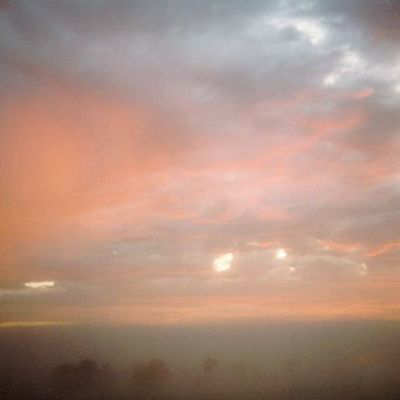

In [11]:
PIL.Image.open(str(Ac[1]))

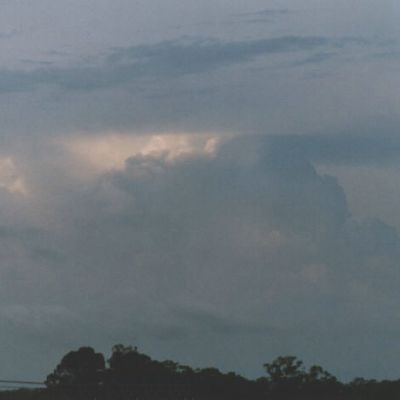

In [12]:
St = list(data_dir.glob('St/*'))
PIL.Image.open(str(St[0]))

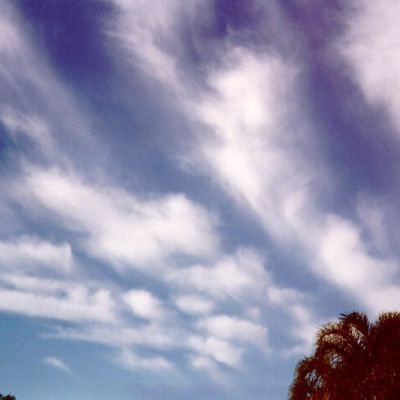

In [13]:
Ci = list(data_dir.glob('Ci/*'))
PIL.Image.open(str(Ci[0]))

# 데이터 세트 만들기

In [14]:
batch_size = 32
img_height = 180
img_width = 180

# 전체 이미지에서 훈련 이미지 80% 검증 이미지 20%로 나누기

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2323 files belonging to 11 classes.
Using 1859 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2323 files belonging to 11 classes.
Using 464 files for validation.


# class_name 재설정하기

In [17]:
class_names = train_ds.class_names
print(class_names)

['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']


In [18]:
class_names = ['고적운(altocumulus, Ac)', '고도층(altostratus, As)', '적란운(cumulonimbus, Cb)',
               '권적운(cirrocumulus, Cc)', '권운(cirrus, Ci)', '권층운(cirrostratus, Cs)', 
               '비행운(contrail, Ct)', '적운(cumulus, Cu)', '후광층(nimbostratus, Ns)',
               '성층적운(stratocumulus, Sc)', '충운(stratus, St)'
               ]
print(class_names)

['고적운(altocumulus, Ac)', '고도층(altostratus, As)', '적란운(cumulonimbus, Cb)', '권적운(cirrocumulus, Cc)', '권운(cirrus, Ci)', '권층운(cirrostratus, Cs)', '비행운(contrail, Ct)', '적운(cumulus, Cu)', '후광층(nimbostratus, Ns)', '성층적운(stratocumulus, Sc)', '충운(stratus, St)']


# 데이터 세트 시각화하기

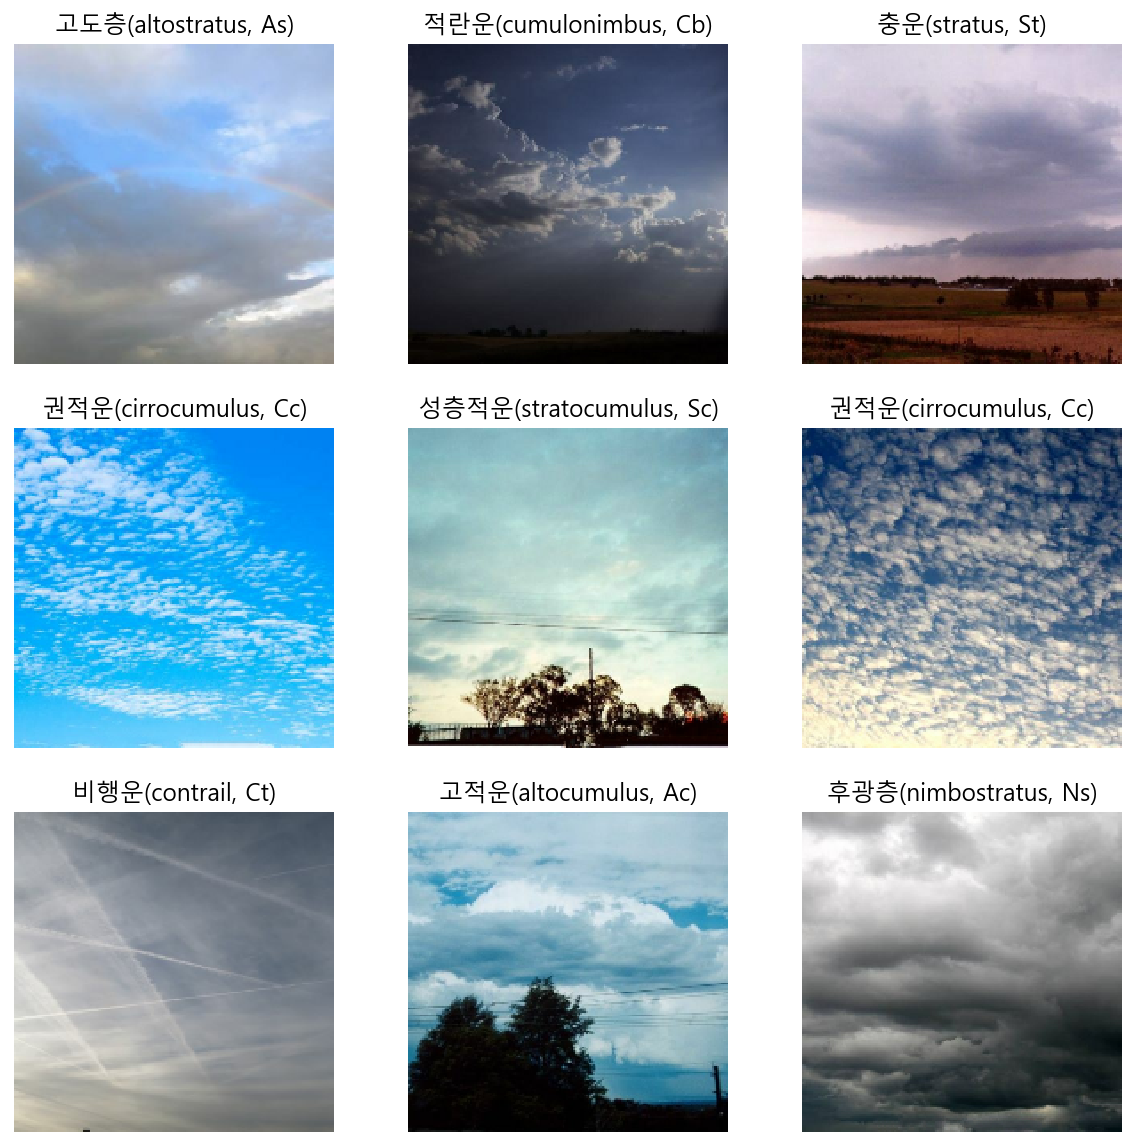

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


# 데이터 세트 구성하기

In [26]:
# tf.data.experimental.AUTOTUNE: tf.data 런타임이 실행 시에 동적으로 값을 조정
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 데이터 표준화하기

In [27]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1/255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0019729785 0.9217139


# 모델 만들기

In [29]:
num_classes = 11

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# 모델 컴파일하기

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 모델 요약

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# 모델훈련

In [33]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
59/59 [==============================] - 20s 327ms/step - loss: 2.2581 - accuracy: 0.1850 - val_loss: 2.1668 - val_accuracy: 0.2888
Epoch 2/30
59/59 [==============================] - 19s 316ms/step - loss: 2.0408 - accuracy: 0.2926 - val_loss: 2.0753 - val_accuracy: 0.2823
Epoch 3/30
59/59 [==============================] - 19s 319ms/step - loss: 1.8531 - accuracy: 0.3588 - val_loss: 2.0518 - val_accuracy: 0.3254
Epoch 4/30
59/59 [==============================] - 19s 317ms/step - loss: 1.6523 - accuracy: 0.4250 - val_loss: 2.0039 - val_accuracy: 0.3341
Epoch 5/30
59/59 [==============================] - 19s 315ms/step - loss: 1.4047 - accuracy: 0.5250 - val_loss: 2.0539 - val_accuracy: 0.3276
Epoch 6/30
59/59 [==============================] - 19s 316ms/step - loss: 1.1307 - accuracy: 0.6143 - val_loss: 2.2993 - val_accuracy: 0.3125
Epoch 7/30
59/59 [==============================] - 19s 317ms/step - loss: 0.8820 - accuracy: 0.7111 - val_loss: 2.5712 - val_accuracy: 0.3297

# 훈련결과시작하기

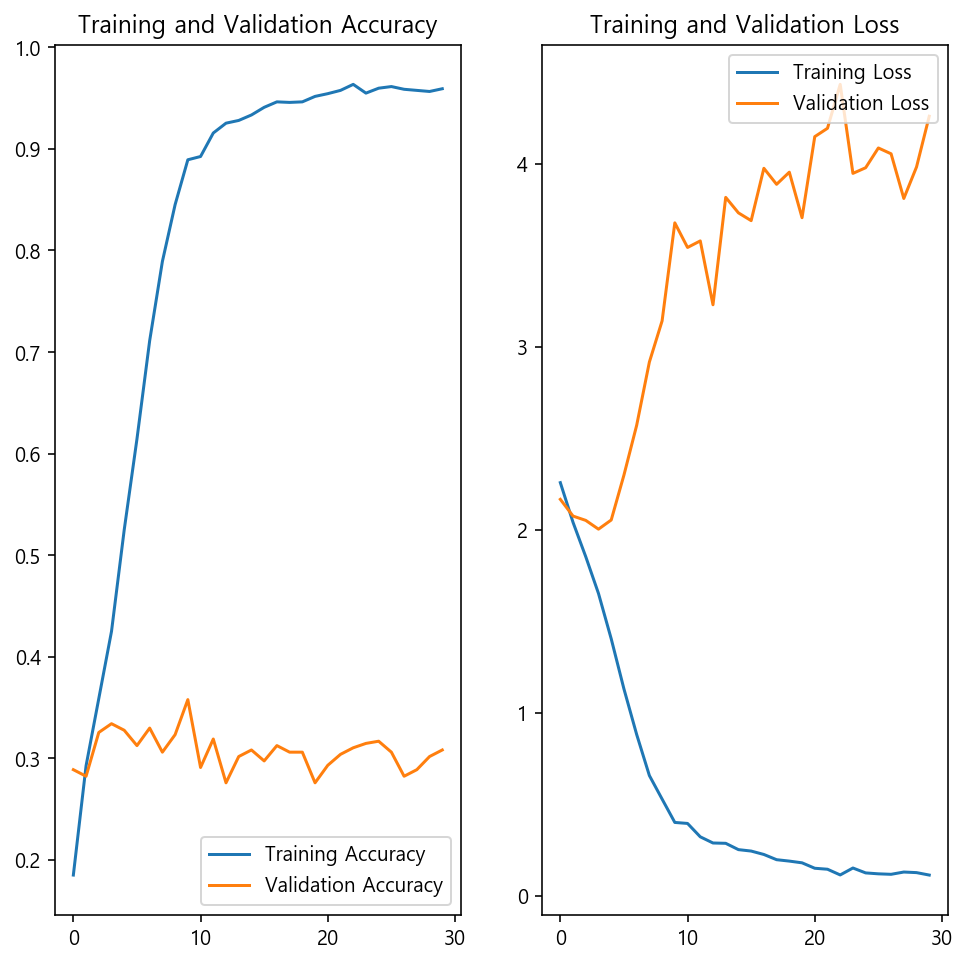

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 데이터 증강

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


# 증강한 데이터 시각화

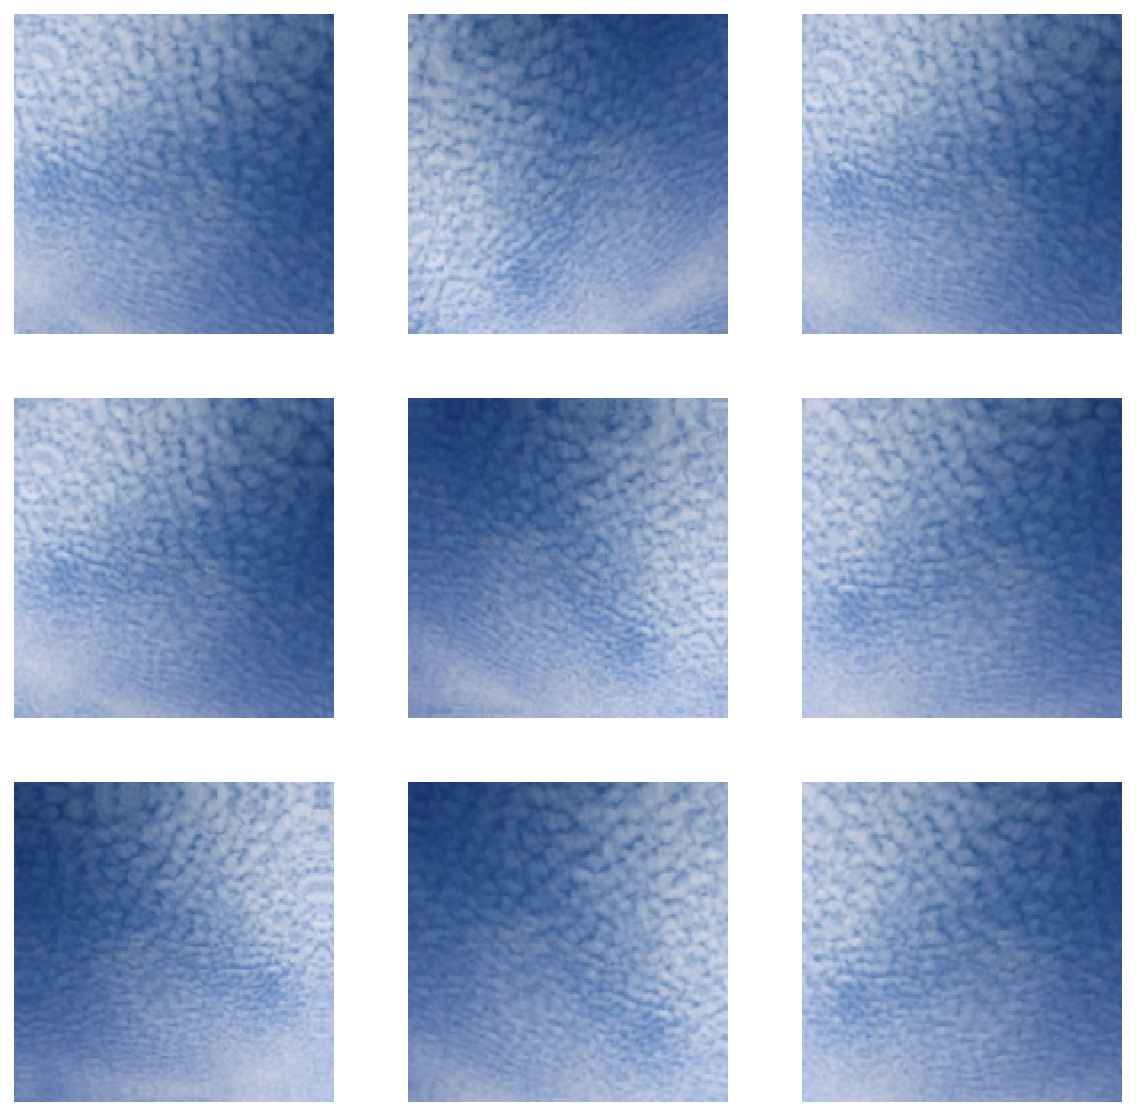

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [38]:
# 모델 재구성

In [39]:
model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# 재구성한 모델 컴파일 및 훈련

In [43]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [45]:
epochs=30
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
59/59 [==============================] - 27s 449ms/step - loss: 2.3069 - accuracy: 0.1824 - val_loss: 2.2009 - val_accuracy: 0.2134
Epoch 2/30
59/59 [==============================] - 25s 423ms/step - loss: 2.1123 - accuracy: 0.2571 - val_loss: 2.1252 - val_accuracy: 0.2823
Epoch 3/30
59/59 [==============================] - 25s 425ms/step - loss: 2.0287 - accuracy: 0.2856 - val_loss: 2.1302 - val_accuracy: 0.2694
Epoch 4/30
59/59 [==============================] - 24s 409ms/step - loss: 1.9578 - accuracy: 0.3082 - val_loss: 2.0684 - val_accuracy: 0.3103
Epoch 5/30
59/59 [==============================] - 26s 439ms/step - loss: 1.9324 - accuracy: 0.3029 - val_loss: 2.0553 - val_accuracy: 0.3039
Epoch 6/30
59/59 [==============================] - 25s 422ms/step - loss: 1.9061 - accuracy: 0.3287 - val_loss: 2.0290 - val_accuracy: 0.3039
Epoch 7/30
59/59 [==============================] - 24s 414ms/step - loss: 1.8550 - accuracy: 0.3491 - val_loss: 2.0049 - val_accuracy: 0.3621

# 훈련 결과 시각화

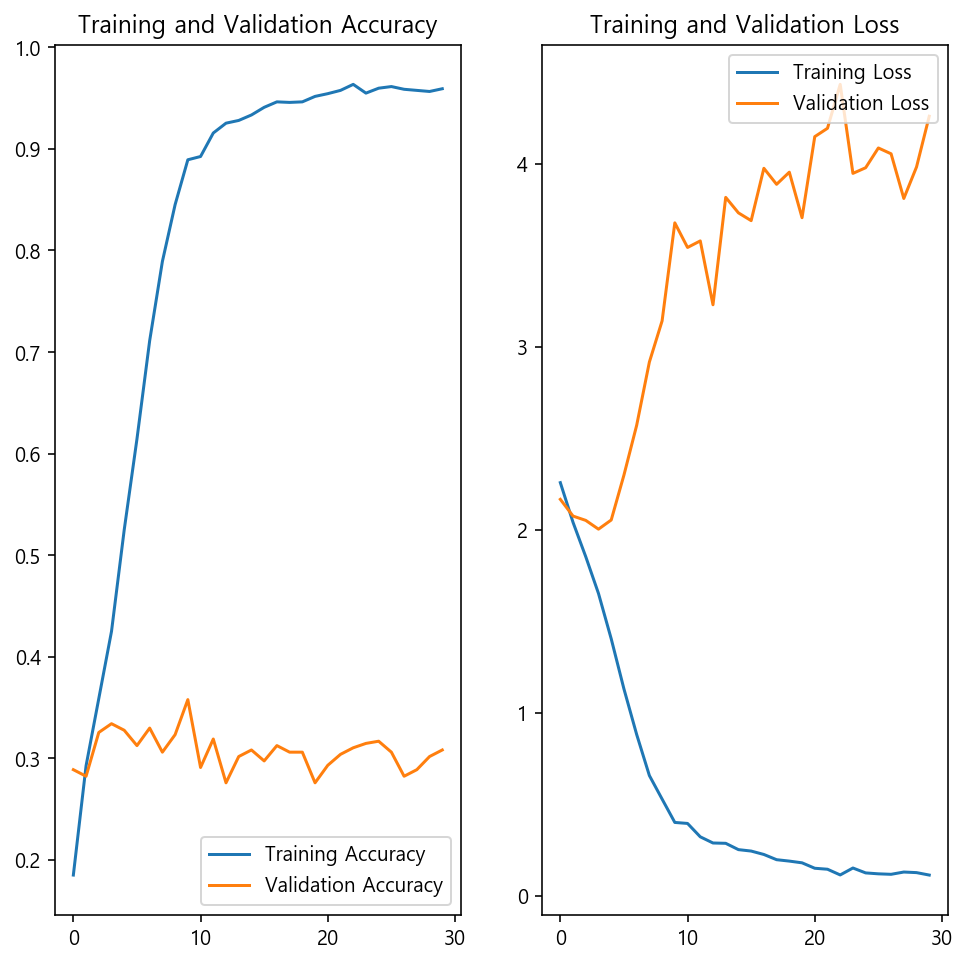

In [46]:
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 모델 저장

In [47]:
model.save('C:/Users/hi/Desktop/DeepLearning/data/cloud_model.h7')

INFO:tensorflow:Assets written to: C:/Users/hi/Desktop/DeepLearning/data/cloud_model.h7\assets


# 새로운 데이터 예측

In [48]:
change_dir = os.chdir("C:/Users/hi/Anaconda3/jupiter/day22_mongoDB_chatbot/chatbot_Project(4category)/cloud_data/test/")

In [49]:
test_dir = pathlib.Path(os.getcwd())

In [50]:
test_dir

WindowsPath('C:/Users/hi/Anaconda3/jupiter/day22_mongoDB_chatbot/chatbot_Project(4category)/cloud_data/test')

In [51]:
test_imagelist = list(test_dir.glob('*'))

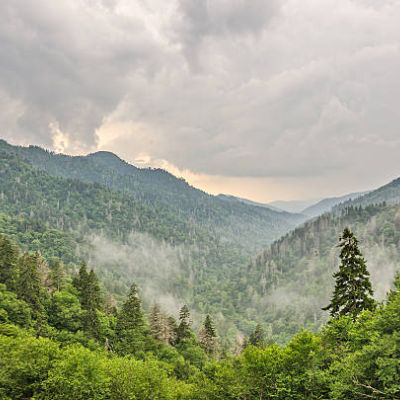

In [52]:
PIL.Image.open(str(test_imagelist[200]))

In [54]:
img = keras.preprocessing.image.load_img(
    test_imagelist[200], target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

model = load_model('C:/Users/hi/Desktop/DeepLearning/data/cloud_model.h7')

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "{:.2f}%의 확률로 {}으로 예측됨"
    .format(100 * np.max(score), class_names[np.argmax(score)])
)

85.59%의 확률로 권층운(cirrostratus, Cs)으로 예측됨
